In [1]:
import os.path
import matplotlib.pyplot as plt

import ramanchada2 as rc2
import ramanchada2.misc.constants as rc2const
from ramanchada2.protocols.calibration import CalibrationModel
import pandas as pd
import numpy as np
import traceback
import warnings 
warnings.filterwarnings("ignore")


In [2]:
#
def find_peaks(spe_test,profile="Gaussian"):
    find_kw={"wlen": 200, "width": 1, "sharpening" : None}
    find_kw["prominence"] = spe_test.y_noise_MAD() * 3
    cand = spe_test.find_peak_multipeak(**find_kw)
    fit_kw = {}
    return spe_test.fit_peak_multimodel(profile=profile,candidates=cand, **fit_kw ,no_fit=False) 

# 1. Load Ne and Si spectra
and do basic preprocessing and plotting

In [3]:

# 
laser_wl = 785

In [4]:
# We use test spectra for this demo.  You can load the spectra from local files instead.
provider = "ICV"
optical_path = "100"
device = "BWtek"


print(f"We will load test spectra by {provider} {device} laser wavelength {laser_wl} optical path {optical_path}.")

We will load test spectra by ICV BWtek laser wavelength 785 optical path 100.


<Axes: >

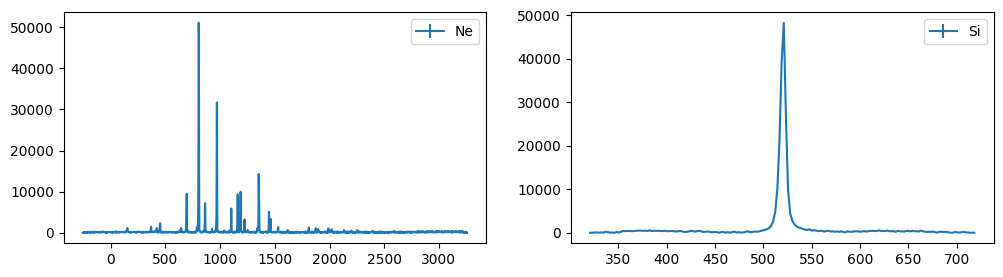

In [5]:
spe_neon = rc2.spectrum.from_test_spe(
            sample=["Neon"], provider=[provider], device=[device], OP=[optical_path], laser_wl=[str(laser_wl)]
        )
spe_neon = spe_neon.subtract_baseline_rc1_snip(niter= 40)

spe_sil = rc2.spectrum.from_test_spe(
            sample=["S0B"], provider=[provider], device=[device], OP=[optical_path], laser_wl=[str(laser_wl)]
        )

spe_sil = spe_sil.trim_axes(
            method="x-axis", boundaries=(max(100, 520.45 - 200), 520.45 + 200)
        ).subtract_baseline_rc1_snip(niter= 40)

# Plot spectra
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,3))
spe_neon.plot(label='Ne',ax=ax1)
spe_sil.plot(label="Si",ax=ax2)

# 2. Create calibration model (both Si and Ne)


In [6]:
try:
    fit_neon_peaks = True
    # False should be used for testing only . Fitting may take a while .
    neon_wl = rc2const.NEON_WL[laser_wl]
    calmodel = CalibrationModel.calibration_model_factory(
        laser_wl,
        spe_neon,
        spe_sil,
        neon_wl=neon_wl,
        find_kw={"wlen": 200, "width": 1},
        fit_peaks_kw={},
        should_fit=fit_neon_peaks,
        match_method="cluster"  # "assignment"
    )
    assert len(calmodel.components) == 2
    print(type(calmodel.components[0]),calmodel.components[0])
    print(type(calmodel.components[1]),calmodel.components[1])
    #print(calmodel.components[1].profile, calmodel.components[1].peaks)
except Exception as _err:
    calmodel = None
    traceback.print_exc()

<class 'ramanchada2.protocols.calibration.XCalibrationComponent'> Neon calibration spe (cm-1) reference (nm) model (nm) Calibration curve 37 points) thin_plate_spline
<class 'ramanchada2.protocols.calibration.LazerZeroingComponent'> Laser zeroing using 818.3166492896055 nm 520.45 cm-1 (Pearson4)  spe (nm) reference (cm-1) model (nm) 818.3166492896055


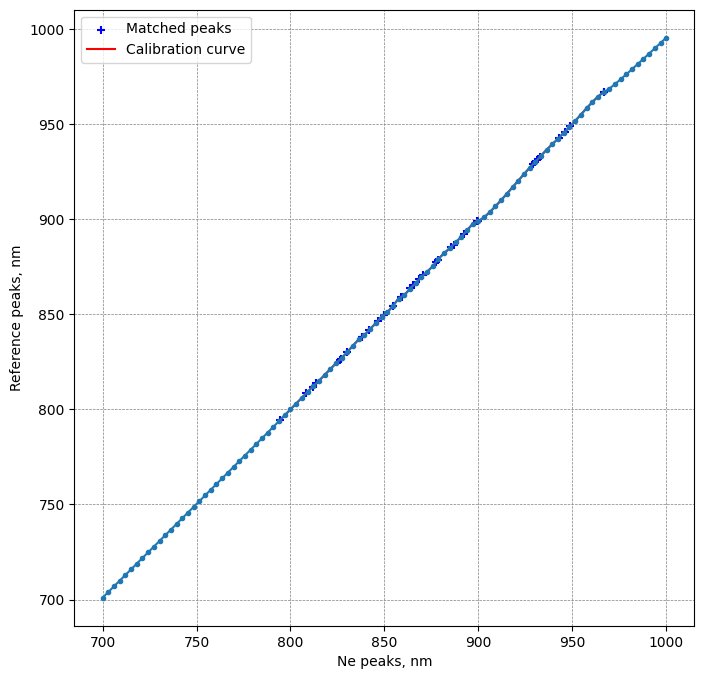

In [ ]:
# plot calibration curve

model_neon = calmodel.components[0]
fig,ax=plt.subplots(1,1,figsize=(8,8))

model_neon.model.plot(ax=ax )

# one can apply the calibration curve to arbitrary vector
# x_range = np.linspace(700,1000, 100)  
# predicted_x =  model_neon.model(x_range.reshape(-1, 1)) 
# ax.plot(x_range,predicted_x,marker='.')


In [8]:
model_neon.matched_peaks  

,Wavelength,Intensity,Source,Cluster
0,794.473447,0.051019,spe,7
1,801.336525,0.013877,spe,24
2,808.418043,0.055537,spe,23
3,811.853445,0.036017,spe,38
4,813.820526,0.084513,spe,1
...,...,...,...,...
96,953.470460,0.068010,reference,12
97,954.783370,0.030227,reference,12
98,957.759300,0.143577,reference,34
99,966.599562,0.219144,reference,2


In [9]:
# calmodel.components[0].matched_peaks

# 3. Apply calibration

In [10]:
# This is the only row we need for calibrating a new spectrum
spe_sil_calibrated = calmodel.apply_calibration_x(spe_sil)


In [11]:
# Let's verfy the peak in the calibrated Si is at the right position 
       

fitres = find_peaks(spe_sil_calibrated,profile="Pearson4")
df = fitres.to_dataframe_peaks().sort_values(by="height",ascending=False)
df.head(1)

,amplitude,amplitude_stderr,center,center_stderr,sigma,sigma_stderr,expon,expon_stderr,skew,skew_stderr,fwhm,fwhm_stderr,height,height_stderr,position,position_stderr
g00_p3,414019.755477,None,520.451121,None,3.966692,None,1.435542,None,0.326552,None,6.60104,None,49696.126969,None,519.999956,None


In [12]:
si_peak_found = df.iloc[0]["center"]

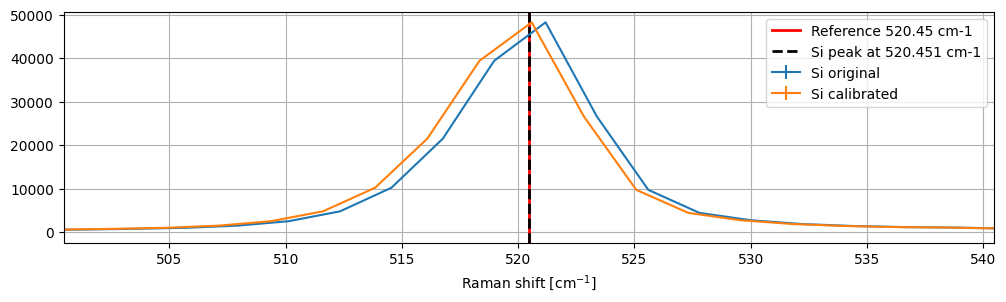

In [13]:
# plots
fig, ax = plt.subplots(1,1,figsize=(12,3))
spe_sil.plot(ax=ax,label="Si original")
spe_sil_calibrated.plot(ax=ax,label="Si calibrated")
ax.set_xlabel('Raman shift [cm$^{-1}$]')
ax.axvline(x=520.45, color='red', linestyle='-', linewidth=2, label="Reference 520.45 cm-1")
ax.set_xlim(520.45-20,520.45+20)
ax.axvline(x=si_peak_found, color='black', linestyle='--', linewidth=2, label="Si peak at {:.3f} cm-1".format(si_peak_found))
ax.legend()
plt.grid()
plt.show()

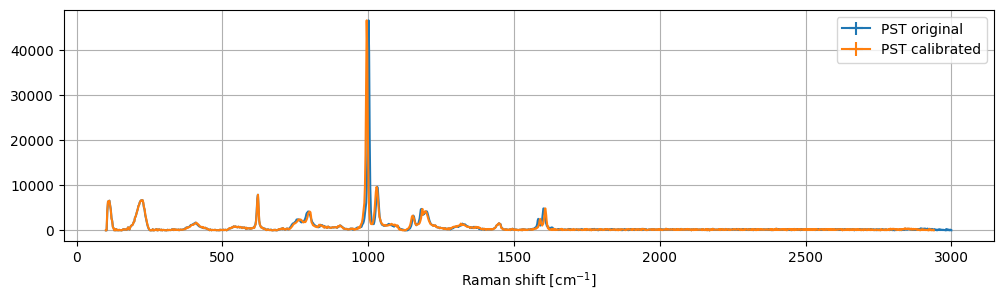

In [14]:
# apply calibration to another spectrum (e.g. PST)
spe_pst = rc2.spectrum.from_test_spe(
            sample=["PST"], provider=[provider], device=[device], OP=[optical_path], laser_wl=[str(laser_wl)]
        )
spe_pst = spe_pst.trim_axes(method="x-axis", boundaries=(100, max(spe_pst.x))).subtract_baseline_rc1_snip(niter= 40)
spe_pst_calibrated = calmodel.apply_calibration_x(spe_pst)

# plots
fig, ax = plt.subplots(1,1,figsize=(12,3))
spe_pst.plot(ax=ax,label="PST original")
spe_pst_calibrated.plot(ax=ax,label="PST calibrated")
ax.set_xlabel('Raman shift [cm$^{-1}$]')
ax.legend()
plt.grid()
plt.show()


# ************ That's it ! ************

# 4. For advanced users 

One can create the components of the calibration model one by one to hae a full control of the options. 
However, the final result will be the same.  The recommended way is to use the calibration_model_factory as above.

## 4.1. Create calibration curve using Neon

In [15]:
# 4.1 Create calibration curve using Neon

fit_neon_peaks = True
# False should be used for testing only . Fitting may take a while .

neon_wl = rc2const.NEON_WL[laser_wl]
# these are reference Ne peaks

try:
    find_kw = {"wlen": 200, "width": 1}
    # options for finding peaks    
    fit_peaks_kw = {}
    # options for fitting peaks

    calmodel1 = CalibrationModel(laser_wl)
    # create CalibrationModel class. it does not derive a curve at this moment!
    calmodel1.prominence_coeff = 3
    find_kw["prominence"] = spe_neon.y_noise_MAD() * calmodel1.prominence_coeff

    model_neon1 = calmodel1.derive_model_curve(
        spe=spe_neon,
        ref=neon_wl,
        spe_units="cm-1",
        ref_units="nm",
        find_kw=find_kw,
        fit_peaks_kw=fit_peaks_kw,
        should_fit=fit_neon_peaks,
        name="Neon calibration",
        match_method="cluster"
    )
    # now derive_model_curve finds peaks, fits peaks, matches peaks and derives the calibration curve
    # and model_neon.process() could be applied to Si or other spectra

except Exception as err:
    traceback.print_exc()


In [16]:
print(model_neon1)

Neon calibration spe (cm-1) reference (nm) model (nm) Calibration curve 37 points) thin_plate_spline


## 4.1.1 Explore the calibration curve (optional)

The Ne spectrum is converted to wavelength, nm , peaks are matched to the reference peaks and calibration curve is derived

,center,fwhm,height,amplitude
0,770.394532,0.079126,3968.509669,3.058729e+01
1,1013.071961,0.483602,4376.835464,7.932729e+18
2,776.377121,0.855382,156.783007,3.325932e+03
3,775.574249,0.099564,2388.875328,3.880813e+01
4,780.986059,0.165853,679.898702,7.275547e+01
...,...,...,...,...
94,1035.760292,1.457904,103.450769,2.380852e+02
96,1039.792599,1.145680,234.188654,2.268111e+03
97,1046.834956,0.289707,20.117035,1.362162e-03
98,1048.570052,3.076862,208.124125,1.691060e+03


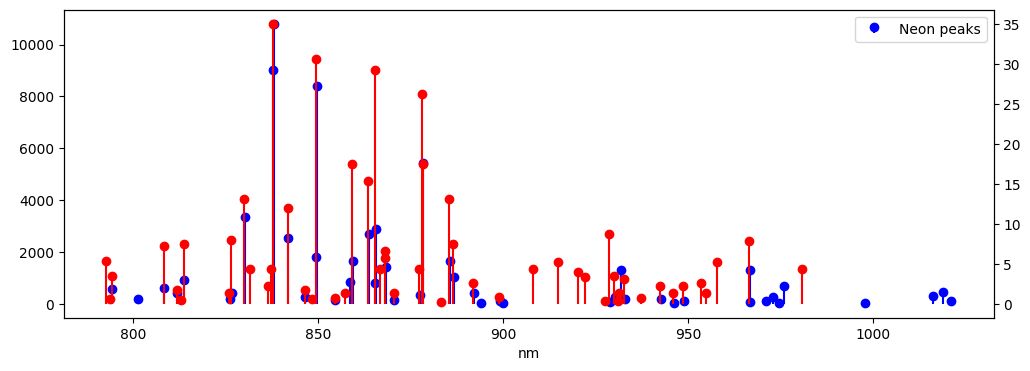

In [17]:
# Quick plott of Ne peaks (blue) and references (red)
calmodel1.plot()
model_neon1.peaks

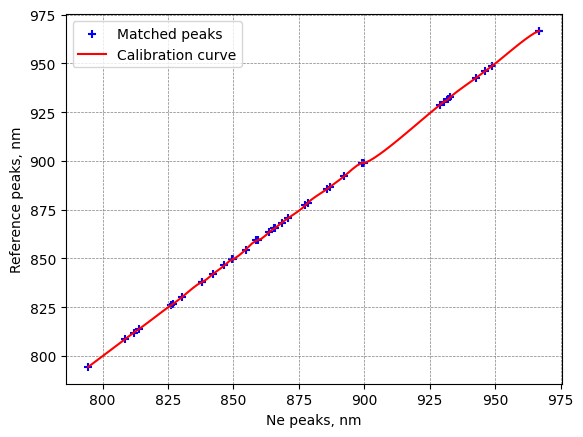

In [18]:
fig, ax = plt.subplots(1,1)
model_neon.model.plot(ax=ax)

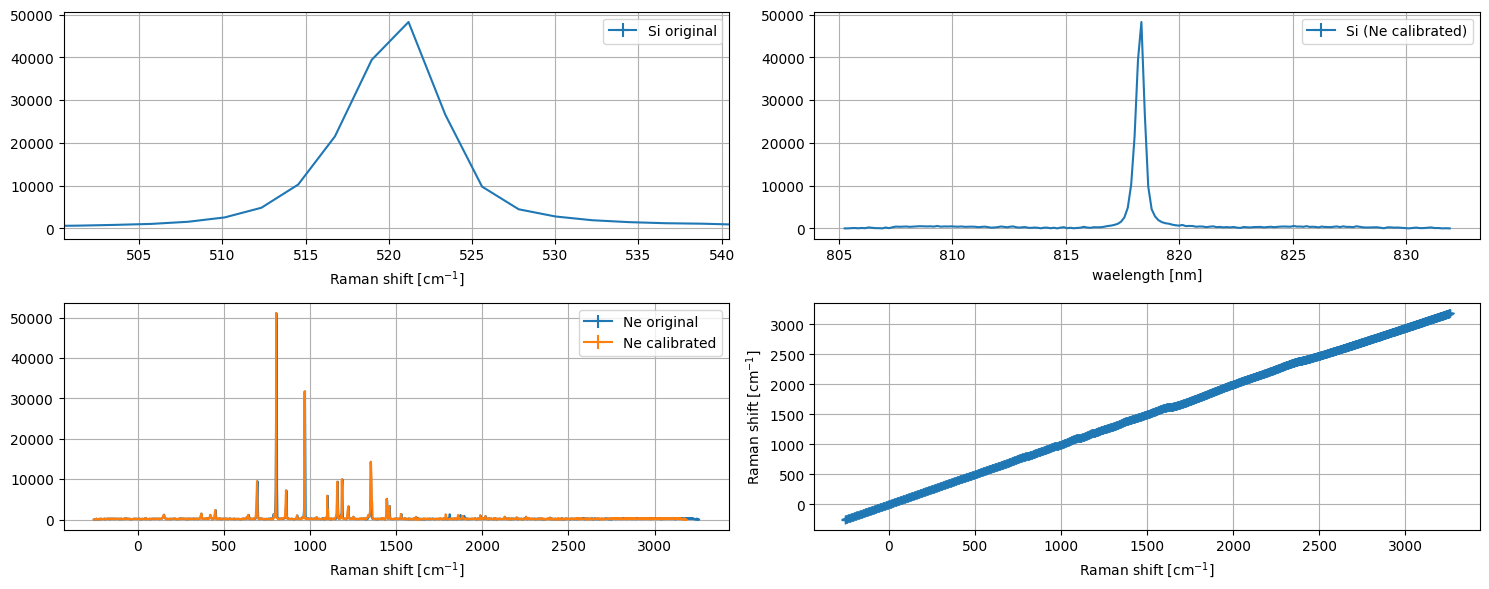

In [19]:
# we can calibrate Ne according to the calibration curve derived using Neon peaks
spe_ne_cm1 = model_neon1.process(spe_neon,convert_back=True)

# we can calibrate Si according to the calibration curve derived using Neon peaks
#spe_sil_x1_cm1 = model_neon.process(spe_sil,convert_back=True)

fig, axes = plt.subplots(2,2,figsize=(15,6))

ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

spe_sil.plot(ax=ax1,label="Si original")
#spe_sil_x1_cm1.plot(ax=ax1,label="Si (Ne calibrated)")
ax1.set_xlim(520.45-20,520.45+20)
ax1.set_xlabel('Raman shift [cm$^{-1}$]')
ax1.grid()

spe_sil_x1_nm = model_neon.process(spe_sil,convert_back=False)
spe_sil_x1_nm.plot(ax=ax2,label="Si (Ne calibrated)")
ax2.set_xlabel('waelength [nm]')
ax2.grid()


spe_neon.plot(ax=ax3,label="Ne original")
spe_ne_cm1.plot(ax=ax3,label="Ne calibrated")
ax3.set_xlabel('Raman shift [cm$^{-1}$]')
ax3.grid()

ax4.plot(spe_neon.x,spe_ne_cm1.x,marker="+")
#ax4.set_xlim(520.45-20,520.45+20)
#ax4.set_ylim(520.45-20,520.45+20)
ax4.set_xlabel('Raman shift [cm$^{-1}$]')
ax4.set_ylabel('Raman shift [cm$^{-1}$]')
ax4.grid()
fig.suptitle="Ne calibration only"
plt.tight_layout()
plt.show()

## 4.2. Laser zeroing

- The Si spectrum is processed through Ne calibration curve, which results in spectrum in wavelength (nm)
- Then the Si peak is found and fit (in nm)
- Finally the peak position is used in the laser zeroing formula , which converts the x-axis into wavenumber (cm<sup>-1</sup>)

```
def zero_nm_to_shift_cm_1(self, wl, zero_pos_nm, zero_ref_cm_1=520.45):
        return 1e7 * (1 / zero_pos_nm - 1 / wl) + zero_ref_cm_1
```        

In [20]:
# The second step of the X calibration - Laser zeroing
# 
try:           
        find_kw = {"wlen": 200, "width": 1}
        # options for finding peaks    
        fit_peaks_kw = {}
        # options for fitting peaks         
        spe_sil_ne_calib = model_neon.process(
            spe_sil, spe_units="cm-1", convert_back=False
        )   
        calmodel1.prominence_coeff = 3
        find_kw["prominence"] = (
            spe_sil_ne_calib.y_noise_MAD() * calmodel.prominence_coeff
        )        
        calmodel1.derive_model_zero(
            spe=spe_sil_ne_calib,
            ref={520.45: 1},
            spe_units=model_neon.model_units,
            ref_units="cm-1",
            find_kw=find_kw,
            fit_peaks_kw=fit_peaks_kw,
            should_fit=True,
            name="Si calibration",
            profile="Pearson4"
        )
except Exception as err:
    traceback.print_exc()

### 4.2.1  Explore laser zeroing component (optional)

In [21]:
# Now calmodel has two components , derived with Ne and Si respectively

# we can access them individually (optional)
model_neon= calmodel1.components[0]
print(type(model_neon))
print(model_neon)
model_si= calmodel1.components[1]
print(type(model_si))
print(model_si)

<class 'ramanchada2.protocols.calibration.XCalibrationComponent'>
Neon calibration spe (cm-1) reference (nm) model (nm) Calibration curve 37 points) thin_plate_spline
<class 'ramanchada2.protocols.calibration.LazerZeroingComponent'>
Laser zeroing using 818.3166492896055 nm 520.45 cm-1 (Pearson4)  spe (nm) reference (cm-1) model (nm) 818.3166492896055


In [22]:
# These are the Si peaks (in nm) . The top peak is ALWAYS converted to the reference value (520.45 cm<sup>-1</sup>) due to laser zeroing formula
model_si.peaks.head()

,center,fwhm,height,amplitude
3,818.316649,0.441963,49694.123989,27716.114810
4,825.189765,0.693582,47.203527,2643.247667
5,827.909635,0.090956,25.814879,165.175637


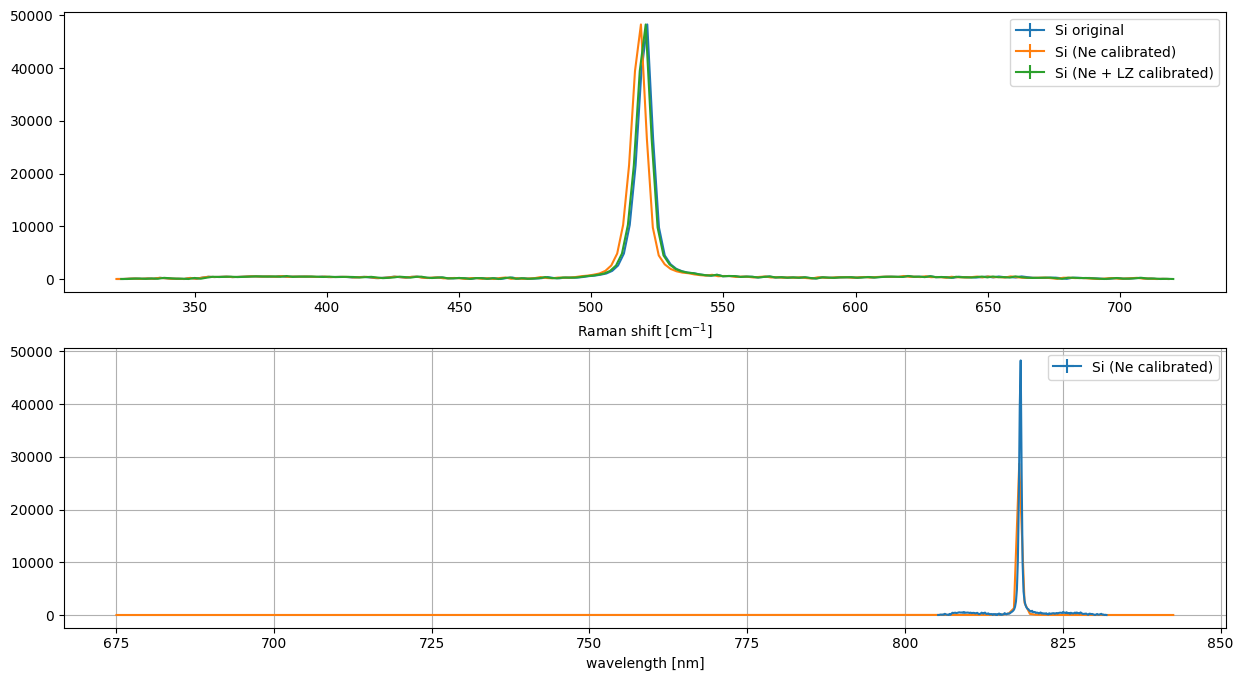

In [23]:
# These plots are for illustration , there are easier way to do calibration, see below
fig, axes = plt.subplots(2,1,figsize=(15,8))
spe_sil_xcstep1_nm = model_neon.process(spe_sil)
spe_sil_xcstep1_cm1 = model_neon.process(spe_sil,convert_back=True)
spe_sil_xcstep2_cm1 = model_si.process(spe_sil_x1_nm)

spe_sil.plot(ax = axes[0],label="Si original")
spe_sil_xcstep1_cm1.plot(ax = axes[0],label="Si (Ne calibrated)")
spe_sil_xcstep2_cm1.plot(ax = axes[0],label="Si (Ne + LZ calibrated)")
axes[0].set_xlabel('Raman shift [cm$^{-1}$]')
# 
spe_sil_xcstep1_nm.plot(ax = axes[1],label="Si (Ne calibrated)")
model_si.fit_res.plot(ax = axes[1])
axes[1].set_xlabel("wavelength [nm]")
plt.grid()

# 4.3. Apply x-calibration

In [24]:
# That's it , one line to apply both steps of the calibration 
spe_sil_calibrated = calmodel1.apply_calibration_x(spe_sil)


# 4.4. Plot and verify results

The Si peak of the calibrated spectrum (Gaussian) 520.1362934879866


,amplitude,amplitude_stderr,center,center_stderr,sigma,sigma_stderr,fwhm,fwhm_stderr,height,height_stderr
g00_p3,144887.189048,7893.266528,520.136293,0.027106,2.010464,0.044934,4.734280,0.105812,28750.397215,1005.485276
g00_p4,228512.231461,7664.872371,519.130414,0.071234,4.444798,0.090029,10.466700,0.212003,9440.705473,1027.153094
g00_p5,104797.656962,8320.886053,553.308094,6.420565,73.089205,7.084509,6.636440,16.682743,572.016324,43.969297
g00_p0,19828.887216,19556.469822,374.677851,19.588511,17.786348,12.458714,41.883649,29.338029,444.755816,170.601206
g00_p2,7076.259898,21049.769415,407.043643,19.294171,12.249829,20.045866,7.223402,47.204407,230.453778,365.257837


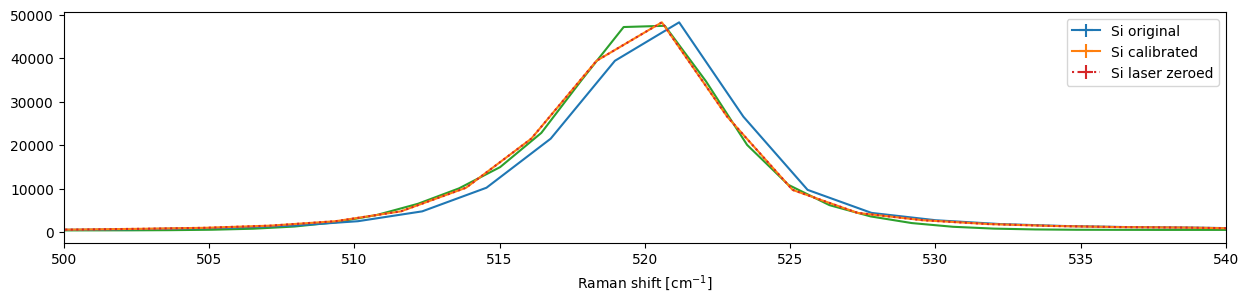

In [25]:
#Plot
fig, ax = plt.subplots(1,1,figsize=(15,3))
spe_sil.plot(label="Si original",ax=ax)
spe_sil_calibrated.plot(ax=ax,label="Si calibrated")
ax.set_xlabel('Raman shift [cm$^{-1}$]')
# 
ax.set_xlim(520-20,520+20)
# let's check the Si peak
si_peak = 520.45
spe_test = spe_sil_calibrated #.trim_axes(method='x-axis',boundaries=(si_peak-50,si_peak+50))

fitres = find_peaks(spe_test,profile="Gaussian")
     
fitres.plot(ax=ax,label="fit res")
spe_test.plot(ax=ax,label="Si laser zeroed", fmt=":")
df = fitres.to_dataframe_peaks().sort_values(by="height",ascending=False)
print("The Si peak of the calibrated spectrum (Gaussian)", df.iloc[0]["center"])

df.head()


The Si peak of the calibrated spectrum (Pearson4) 520.4511212851771


,amplitude,amplitude_stderr,center,center_stderr,sigma,sigma_stderr,expon,expon_stderr,skew,skew_stderr,fwhm,fwhm_stderr,height,height_stderr,position,position_stderr
g00_p3,414019.755477,None,520.451121,None,3.966692,None,1.435542,None,0.326552,None,6.601040,None,49696.126969,None,519.999956,None
g00_p0,333409.660069,None,-7877.365560,None,14221.017635,None,962.656215,None,-122.251949,None,127.955702,None,409.416069,None,-6974.370756,None
g00_p4,38846.504866,None,650.172112,None,-1262.753306,None,925.501572,None,4.934124,None,10.187254,None,47.203527,None,653.538169,None
g00_p1,2584.910942,None,437.513935,None,-21.496292,None,142.199390,None,4.645352,None,1.999679,None,28.363363,None,437.865054,None
g00_p5,2272.541046,None,681.661877,None,-52.025217,None,778.151148,None,17.500046,None,1.327288,None,25.814879,None,682.246881,None


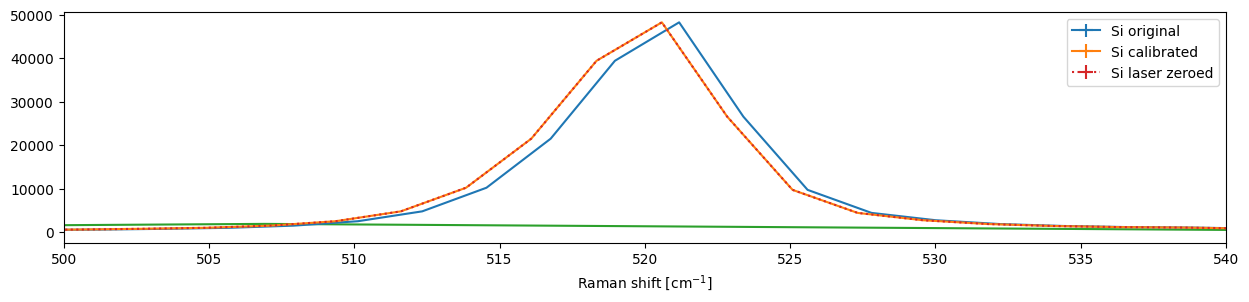

In [26]:
fig, ax1 = plt.subplots(1,1,figsize=(15,3))

spe_sil.plot(label="Si original",ax=ax1)
spe_sil_calibrated = calmodel1.apply_calibration_x(spe_sil)
spe_sil_calibrated.plot(ax=ax1,label="Si calibrated")
ax1.set_xlabel('Raman shift [cm$^{-1}$]')
ax1.set_xlim(520-20,520+20)
ax.axvline(x=520.45, color='red', linestyle='-', linewidth=2, label="Reference 520.45 cm-1")
spe_test = spe_sil_calibrated #.trim_axes(method='x-axis',boundaries=(si_peak-50,si_peak+50))
fitres = find_peaks(spe_test,profile="Pearson4")
     
fitres.plot(ax=ax1,label="fit res")
spe_test.plot(ax=ax1,label="Si laser zeroed", fmt=":")
df = fitres.to_dataframe_peaks().sort_values(by="height",ascending=False)


print("The Si peak of the calibrated spectrum (Pearson4)", df.iloc[0]["center"])
df.head()